# Train and test AVIDNet

In [1]:
import torch
import os
from torchsummary import summary
from collections import defaultdict

from datasets.utils import separate_datasets, get_data_loaders, show_samples
from datasets.transforms import get_data_transforms
from models.model import get_model
from models.train import train_model
from models.metrics import update_mean_metrics, print_metrics

ModuleNotFoundError: No module named 'torch'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NameError: name 'torch' is not defined

## Load data

In [3]:
fold = 5
labeled_num_per_cls, mu = 25, 4
batch_size = 6
data_dir = 'data/CXR/train-test'
lb_partial_dir = 'train_lb/train_lb_'
dataset_types = ['train', 'test'] # ['train', 'val', 'test']

In [4]:
# separate_datasets(data_dir, fold, labeled_num_per_cls, mu)

{'train': 75, 'test': 1578}


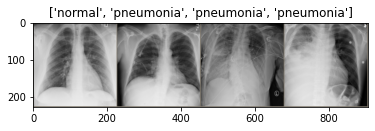

In [5]:
data_transforms = get_data_transforms()
data_loaders, dataset_sizes, class_names = get_data_loaders(data_transforms, fold, batch_size,
                                                            dataset_types, data_dir, lb_partial_dir)
print(dataset_sizes)
show_samples(data_loaders, class_names, dataset_type='train')

## Train the model

In [6]:
trained_models = []
cls_names = ['COVID-19', 'Pneumonia', 'Normal']
metric_types = ['acc', 'ppv', 'recall', 'f1'] # metric_types = ['acc']
mean_metrics = {m_type: defaultdict(float) for m_type in metric_types}
for i in range(fold):
    model_ft, criterion, optimizer_ft, exp_lr_scheduler = get_model(device, fine_tuning=False)
    model, metrics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, i, cls_names,
                                 metric_types, dataset_types, data_loaders, dataset_sizes, device,
                                 num_epochs=20, is_early=False)
    trained_models.append(model)
    mean_metrics = update_mean_metrics(cls_names, mean_metrics, metrics, status='training')

mean_metrics = update_mean_metrics(cls_names, mean_metrics, status='final', fold=fold)
print_metrics(mean_metrics, cls_names, phase='Mean results')

--------------------
Model 1
--------------------

Epoch 0/19
----------
[train]
LOSS - 1.1750
ACC - 0.3200
PPV - COVID-19: 0.3182  Pneumonia: 0.2424  Normal: 0.4500 
RECALL - COVID-19: 0.2800  Pneumonia: 0.3200  Normal: 0.3600 
F1 - COVID-19: 0.2979  Pneumonia: 0.2758  Normal: 0.4000 

[test]
LOSS - 1.0862
ACC - 0.3764
PPV - COVID-19: 0.0000  Pneumonia: 0.0000  Normal: 0.3764 
RECALL - COVID-19: 0.0000  Pneumonia: 0.0000  Normal: 1.0000 
F1 - COVID-19: 0.0000  Pneumonia: 0.0000  Normal: 0.5469 

Epoch 1/19
----------
[train]
LOSS - 0.9739
ACC - 0.4933
PPV - COVID-19: 0.5667  Pneumonia: 0.4118  Normal: 0.4643 
RECALL - COVID-19: 0.6800  Pneumonia: 0.2800  Normal: 0.5200 
F1 - COVID-19: 0.6182  Pneumonia: 0.3333  Normal: 0.4906 

[test]
LOSS - 0.9516
ACC - 0.5868
PPV - COVID-19: 0.3691  Pneumonia: 0.6090  Normal: 1.0000 
RECALL - COVID-19: 0.5556  Pneumonia: 0.9819  Normal: 0.0034 
F1 - COVID-19: 0.4435  Pneumonia: 0.7517  Normal: 0.0068 

Epoch 2/19
----------
[train]
LOSS - 0.8646
ACC

[train]
LOSS - 0.5536
ACC - 0.8000
PPV - COVID-19: 0.8462  Pneumonia: 0.7826  Normal: 0.7692 
RECALL - COVID-19: 0.8800  Pneumonia: 0.7200  Normal: 0.8000 
F1 - COVID-19: 0.8628  Pneumonia: 0.7500  Normal: 0.7843 

[test]
LOSS - 0.6141
ACC - 0.7814
PPV - COVID-19: 0.4153  Pneumonia: 0.8452  Normal: 0.8051 
RECALL - COVID-19: 0.7677  Pneumonia: 0.8079  Normal: 0.7441 
F1 - COVID-19: 0.5390  Pneumonia: 0.8261  Normal: 0.7734 

Epoch 19/19
----------
[train]
LOSS - 0.4515
ACC - 0.8533
PPV - COVID-19: 0.9545  Pneumonia: 0.7576  Normal: 0.9000 
RECALL - COVID-19: 0.8400  Pneumonia: 1.0000  Normal: 0.7200 
F1 - COVID-19: 0.8936  Pneumonia: 0.8621  Normal: 0.8000 

[test]
LOSS - 0.5927
ACC - 0.7909
PPV - COVID-19: 0.4675  Pneumonia: 0.8286  Normal: 0.8210 
RECALL - COVID-19: 0.7273  Pneumonia: 0.8520  Normal: 0.7104 
F1 - COVID-19: 0.5692  Pneumonia: 0.8401  Normal: 0.7617 


--------------------
[Best results]
ACC - 0.7909
PPV - COVID-19: 0.4675  Pneumonia: 0.8286  Normal: 0.8210 
RECALL - C

[test]
LOSS - 0.6044
ACC - 0.7674
PPV - COVID-19: 0.3830  Pneumonia: 0.9012  Normal: 0.7239 
RECALL - COVID-19: 0.7273  Pneumonia: 0.7627  Normal: 0.7811 
F1 - COVID-19: 0.5018  Pneumonia: 0.8262  Normal: 0.7514 

Epoch 16/19
----------
[train]
LOSS - 0.4772
ACC - 0.9200
PPV - COVID-19: 0.9259  Pneumonia: 0.9200  Normal: 0.9130 
RECALL - COVID-19: 1.0000  Pneumonia: 0.9200  Normal: 0.8400 
F1 - COVID-19: 0.9615  Pneumonia: 0.9200  Normal: 0.8750 

[test]
LOSS - 0.5971
ACC - 0.7719
PPV - COVID-19: 0.3744  Pneumonia: 0.8902  Normal: 0.7467 
RECALL - COVID-19: 0.7374  Pneumonia: 0.7876  Normal: 0.7542 
F1 - COVID-19: 0.4966  Pneumonia: 0.8358  Normal: 0.7504 

Epoch 17/19
----------
[train]
LOSS - 0.4616
ACC - 0.9200
PPV - COVID-19: 0.9231  Pneumonia: 0.8889  Normal: 0.9545 
RECALL - COVID-19: 0.9600  Pneumonia: 0.9600  Normal: 0.8400 
F1 - COVID-19: 0.9412  Pneumonia: 0.9231  Normal: 0.8936 

[test]
LOSS - 0.5985
ACC - 0.7693
PPV - COVID-19: 0.3541  Pneumonia: 0.8893  Normal: 0.7544 
REC

[train]
LOSS - 0.5405
ACC - 0.8133
PPV - COVID-19: 0.8846  Pneumonia: 0.7200  Normal: 0.8333 
RECALL - COVID-19: 0.9200  Pneumonia: 0.7200  Normal: 0.8000 
F1 - COVID-19: 0.9020  Pneumonia: 0.7200  Normal: 0.8163 

[test]
LOSS - 0.5900
ACC - 0.7871
PPV - COVID-19: 0.6471  Pneumonia: 0.8825  Normal: 0.7042 
RECALL - COVID-19: 0.6667  Pneumonia: 0.7638  Normal: 0.8418 
F1 - COVID-19: 0.6568  Pneumonia: 0.8189  Normal: 0.7669 

Epoch 14/19
----------
[train]
LOSS - 0.4880
ACC - 0.8800
PPV - COVID-19: 0.9545  Pneumonia: 0.8148  Normal: 0.8846 
RECALL - COVID-19: 0.8400  Pneumonia: 0.8800  Normal: 0.9200 
F1 - COVID-19: 0.8936  Pneumonia: 0.8461  Normal: 0.9020 

[test]
LOSS - 0.5628
ACC - 0.8029
PPV - COVID-19: 0.6634  Pneumonia: 0.8676  Normal: 0.7415 
RECALL - COVID-19: 0.6768  Pneumonia: 0.8147  Normal: 0.8064 
F1 - COVID-19: 0.6700  Pneumonia: 0.8403  Normal: 0.7726 

Epoch 15/19
----------
[train]
LOSS - 0.5089
ACC - 0.8533
PPV - COVID-19: 0.9200  Pneumonia: 0.7667  Normal: 0.9000 
RE

[test]
LOSS - 0.5593
ACC - 0.7978
PPV - COVID-19: 0.8194  Pneumonia: 0.9070  Normal: 0.6898 
RECALL - COVID-19: 0.5960  Pneumonia: 0.7605  Normal: 0.8872 
F1 - COVID-19: 0.6901  Pneumonia: 0.8273  Normal: 0.7761 

Epoch 11/19
----------
[train]
LOSS - 0.5088
ACC - 0.8133
PPV - COVID-19: 0.8000  Pneumonia: 0.8148  Normal: 0.8261 
RECALL - COVID-19: 0.8000  Pneumonia: 0.8800  Normal: 0.7600 
F1 - COVID-19: 0.8000  Pneumonia: 0.8461  Normal: 0.7917 

[test]
LOSS - 0.5259
ACC - 0.8181
PPV - COVID-19: 0.7674  Pneumonia: 0.8774  Normal: 0.7500 
RECALL - COVID-19: 0.6667  Pneumonia: 0.8249  Normal: 0.8333 
F1 - COVID-19: 0.7135  Pneumonia: 0.8503  Normal: 0.7895 

Epoch 12/19
----------
[train]
LOSS - 0.4806
ACC - 0.8000
PPV - COVID-19: 1.0000  Pneumonia: 0.7143  Normal: 0.7200 
RECALL - COVID-19: 0.8800  Pneumonia: 0.8000  Normal: 0.7200 
F1 - COVID-19: 0.9362  Pneumonia: 0.7547  Normal: 0.7200 

[test]
LOSS - 0.5221
ACC - 0.8213
PPV - COVID-19: 0.8205  Pneumonia: 0.8883  Normal: 0.7416 
REC

[train]
LOSS - 0.5917
ACC - 0.8000
PPV - COVID-19: 0.8077  Pneumonia: 0.8182  Normal: 0.7778 
RECALL - COVID-19: 0.8400  Pneumonia: 0.7200  Normal: 0.8400 
F1 - COVID-19: 0.8235  Pneumonia: 0.7660  Normal: 0.8077 

[test]
LOSS - 0.6795
ACC - 0.7490
PPV - COVID-19: 0.3269  Pneumonia: 0.9048  Normal: 0.7543 
RECALL - COVID-19: 0.8586  Pneumonia: 0.6983  Normal: 0.8064 
F1 - COVID-19: 0.4735  Pneumonia: 0.7883  Normal: 0.7795 

Epoch 9/19
----------
[train]
LOSS - 0.4917
ACC - 0.9067
PPV - COVID-19: 1.0000  Pneumonia: 0.8800  Normal: 0.8571 
RECALL - COVID-19: 0.8800  Pneumonia: 0.8800  Normal: 0.9600 
F1 - COVID-19: 0.9362  Pneumonia: 0.8800  Normal: 0.9056 

[test]
LOSS - 0.5946
ACC - 0.8029
PPV - COVID-19: 0.5423  Pneumonia: 0.8710  Normal: 0.7720 
RECALL - COVID-19: 0.7778  Pneumonia: 0.8090  Normal: 0.7980 
F1 - COVID-19: 0.6390  Pneumonia: 0.8389  Normal: 0.7848 

Epoch 10/19
----------
[train]
LOSS - 0.5769
ACC - 0.8533
PPV - COVID-19: 0.8400  Pneumonia: 0.8148  Normal: 0.9130 
REC

## Save and load the model

In [10]:
out_dir = 'trained_models/baseline'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

for i, model in enumerate(trained_models):
    torch.save(model, f'trained_models/baseline/baseline_model_{i}.pt')

In [8]:
trained_model = []
for i in range(fold):
    trained_models.append(torch.load(f'models/baseline/baseline_model_{i}.pt'))
    
summary(trained_models[0], (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Reference

- https://tutorials.pytorch.kr/beginner/saving_loading_models.html
- https://stackoverflow.com/questions/42480111/model-summary-in-pytorch

## Evaluate the model - WIP (Work In Process)

In [10]:
# def evaluate_model(model, criterion, optimizer):
#     since = time.time()

#     model.eval()   # Set model to evaluate mode

#     CLS = {0: 'COVID-19', 1: 'Pneumonia', 2: 'Normal'}
#     running_loss = 0.0
#     running_corrects = 0
#     acc, size, fp, fn = defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)

#     # Iterate over data.
#     for inputs, labels in dataloaders['test']:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, labels)

#         # statistics
#         running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)
#         for pred, label in zip(preds, labels.data):
#             size[CLS[label.item()]] += 1
#             if pred == label.data:
#                 acc[CLS[label.item()]] += 1
#             else:
#                 fp[CLS[pred.item()]] += 1
#                 fn[CLS[label.item()]] += 1

#         iter_loss = running_loss / dataset_sizes['test']
#         iter_acc = running_corrects.double() / dataset_sizes['test']

#     print('Loss: {:.4f} Acc: {:.4f}'.format(iter_loss, iter_acc))
#     accs = {c: round(float(n) / size[c], 4) for c, n in acc.items()}
#     ppv = {c: round(float(n) / (acc[c] + sum([s for c_temp, s in fp.items()
#                                               if c_temp != c])), 4)
#            for c, n in acc.items()}
#     recall = {c: round(float(n) / (acc[c] + sum([s for c_temp, s in fn.items()
#                                                  if c_temp != c])), 4)
#               for c, n in acc.items()}
#     print(f'[ACC] COVID-19: {accs["COVID-19"]}, Pnuemonia: {accs["Pneumonia"]}, Normal: {accs["Normal"]}')
#     print(f'[PPV] COVID-19: {ppv["COVID-19"]}, Pnuemonia: {ppv["Pneumonia"]}, Normal: {ppv["Normal"]}')
#     print(f'[Recall] COVID-19: {recall["COVID-19"]}, Pnuemonia: {recall["Pneumonia"]}, Normal: {recall["Normal"]}')

#     time_elapsed = time.time() - since
#     print('Test complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))

In [6]:
# evaluate_model(model_ft, criterion, optimizer_ft)